# Spectral fitting example (4C+21.35, flare)


**To run this, you need the following files, which can be downloaded using the first few cells of this notebook:**
- orientation file (COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori)       
- download unbinned data (COSI-SMEX/DC3/Data/Sources/4C21p35_flare_3months_unbinned_data_filtered_with_SAAcut.fits.gz, COSI-SMEX/DC3/Data/Sources/4C21p35_flare_3months_unbinned_data_filtered_with_SAAcut.fits.gz, COSI-SMEX/DC3/Data/Backgrounds/Ge/AlbedoPhotons_3months_unbinned_data_filtered_with_SAAcut.fits.gz), combine with background and binning     
- detector response (COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip)     

**The binned data are simulations of the 4C+21.35 (flare) and albedo photon background produced using the COSI SMEX mass model. The detector response needs to be unzipped before running the notebook.**

This notebook fits the spectrum of a 4C+21.35 simulated using MEGAlib and combined with background.

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple datasets from different instruments to be used coherently to fit the parameters of source model. A source model typically consists of a list of sources with parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the expected counts given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed up to a scaling factor. Finally, we will fit a Powerlaw function:

$$
f(x) = K \left(\frac{x}{E_{piv}}\right)^{\alpha}
$$

where $K$ (normalization), $\alpha$ (spectral index), are the free parameters, while $E_{piv}$ is the pivot energy which is fixed (and arbitrary).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = B*b_i + s_i(\mathbf{x})
$$

where $B*b_i$ are the estimated counts due to background in each bin with $B$ the amplitude and $b_i$ the shape of the background, and $s_i$ are the corresponding expected counts from the source, the goal is then to find the values of $\mathbf{x} = [K, \alpha]$ and $B$ that maximize $\mathcal{L}$. These are the best estimations of the parameters.

The final module needs to also fit the time-dependent background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

In [1]:
from cosipy import COSILike, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from cosipy.util import fetch_wasabi_file

from scoords import SpacecraftFrame

from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import poisson_conf_interval

import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

from threeML import Band, PointSource, Model, JointLikelihood, DataList
from cosipy import Band_Eflux
from astromodels import Parameter

from pathlib import Path

import os
import corner
from threeML import*
# from astromodels.functions.functions_1D import Log_parabola
# from astromodels.functions.functions_1D import Powerlaw
from astromodels import *


12:33:16 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=227411;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=877263;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#47\47]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=536896;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=595518;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#68\68]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=50044;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=421576;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=715384;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=669991;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=564759;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=97098;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=863773;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=214526;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=336124;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=445293;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

12:33:16 WARNING   ROOT minimizer not available                                                ]8;id=989681;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=464642;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=72952;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=49522;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=288935;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=942578;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=859904;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=862164;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=54076;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=29837;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=358555;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=117140;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

12:33:17 WARNING   No fermitools installed                                              ]8;id=748924;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=908212;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

12:33:17 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=104089;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=91080;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=680407;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=590775;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=621549;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=987030;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Get the data

Define the path to the directory to save the data. The data can be downloaded by running the cells below. Each respective cell also gives the wasabi file path and file size.

In [2]:
data_path = Path("/home/srinadb/cosipy/docs/tutorials/spectral_fits/dataset/")

Download the orientation file (684.38 MB)

In [3]:
# fetch_wasabi_file('COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori', output=str(data_path /'DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori'))


Download the response file (839.62 MB). This needs to be unzipped before running the rest of the notebook

In [4]:
# fetch_wasabi_file('COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip', output=str(data_path / 'ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5.zip'))


Read in the spacecraft orientation file

In [5]:
sc_orientation = SpacecraftFile.parse_from_file(data_path / "DC3_final_530km_3_month_with_slew_15sbins_GalacticEarth_SAA.ori")

Create BinnedData objects for the Crab only, Crab+background, and background only. The Crab only simulation is not used for the spectral fit, but can be used to compare the fitted spectrum to the source simulation

In [6]:
blazar = BinnedData("blazar.yaml")
blazar_bkg = BinnedData("blazar.yaml")
bkg = BinnedData("background.yaml")

Load binned .hdf5 files

In [7]:
blazar.load_binned_data_from_hdf5(binned_data="./4C21p35_flare_binned_data.hdf5")
blazar_bkg.load_binned_data_from_hdf5(binned_data="./4C21p35_flare_AlbedoPhoton_bkg_binned_data.hdf5")
bkg.load_binned_data_from_hdf5(binned_data="./AlbedoPhoton_bkg_binned_data.hdf5")

Define the path to the detector response

In [8]:
dr = str(data_path / "ResponseContinuum.o3.e100_10000.b10log.s10396905069491.m2284.filtered.nonsparse.binnedimaging.imagingresponse_nside8.area.good_chunks.h5") # path to detector response


## Perform spectral fit

Set background parameter, which is used to fit the amplitude of the background, and instantiate the COSI 3ML plugin

In [9]:
bkg_par = Parameter("background_cosi",                                         # background parameter
                     1,                                                        # initial value of parameter
                     min_value=0,                                              # minimum value of parameter
                     max_value=5,                                              # maximum value of parameter
                     delta=1e-3,                                               # initial step used by fitting engine
                     desc="Background parameter for cosi")

cosi = COSILike("cosi",                                                        # COSI 3ML plugin
                 dr = dr,                                                      # detector response
                 data = blazar_bkg.binned_data.project('Em', 'Phi', 'PsiChi'),   # data (source+background)
                 bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                 sc_orientation = sc_orientation,                              # spacecraft orientation
                 nuisance_param = bkg_par,                                     # background parameter
                 earth_occ = True)                                             # Option to account for Earth occultation

Define a point source at the known location with a Powerlaw function spectrum and add it to the model. The initial values of the Powerlaw function parameters are set close to the true values used to simulate the source.

In [10]:
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC3/sources/Extragalactic/4C21p35_flare/4C21p35_flare.source

l = 255.073637
b = 81.659766

index = -2.5
piv = 1e6 * u.keV
K = 1.52e-10 / u.cm / u.cm / u.s / u.keV 

spectrum = Powerlaw()

spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value

spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

source = PointSource("source",                     # Name of source (arbitrary, but needs to be unique)
                     l = l,                        # Longitude (deg)
                     b = b,                        # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

# Optional: free the position parameters
#source.position.l.free = True
#source.position.b.free = True

model = Model(source)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi.set_model(model)

Gather all plugins and combine with the model in a JointLikelihood object, then perform maximum likelihood fit

In [11]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = True)

like.fit()



12:35:03 INFO      set the minimizer to minuit                                             ]8;id=889009;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=547817;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.


         INFO      trial values: -9.8182,-2.5,1 -> logL = -5833080928.016                  ]8;id=270872;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=331917;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.6221,-2.5,1 -> logL = -9296081897.560                  ]8;id=296707;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=223331;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.015,-2.5,1 -> logL = -3627983895.720                  ]8;id=236355;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=364661;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.7985,-2.5,1 -> logL = -6113471135.577                  ]8;id=636362;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=124710;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8378,-2.5,1 -> logL = -5565066813.788                  ]8;id=948641;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=60170;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.45,1 -> logL = -3803650716.557                 ]8;id=588963;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=127294;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.55,1 -> logL = -8894826075.119                 ]8;id=880263;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=40412;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.495,1 -> logL = -5590570641.745                ]8;id=22688;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=854545;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.505,1 -> logL = -6085771601.583                ]8;id=530278;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=716243;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.5,1.0201 -> logL = -5833654511.952             ]8;id=669893;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=19016;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -9.8182,-2.5,0.98007 -> logL = -5832511711.099            ]8;id=176429;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=853530;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:04 INFO      trial values: -10.255,-2.3782,0.17946 -> logL = -602068903.968          ]8;id=124123;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=406859;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.201,-2.3932,0.060275 -> logL = -823458183.281         ]8;id=211030;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=468182;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.328,-2.3577,0.43795 -> logL = -380623073.681          ]8;id=672223;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=471075;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.467,-2.319,1.1831 -> logL = -133194483.598            ]8;id=127663;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=326041;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.552,-2.2955,1.7542 -> logL = -52438828.729            ]8;id=322236;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=411292;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.64,-2.2709,2.3982 -> logL = -2217899.236              ]8;id=300575;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=370110;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.724,-2.2476,3.0197 -> logL = 24604395.673             ]8;id=466862;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=799595;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.791,-2.2288,3.4972 -> logL = 36493694.831             ]8;id=273356;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=113230;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8858 -> logL = 42368876.025             ]8;id=589764;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=708679;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.849,-2.2122,3.8858 -> logL = 42147091.962             ]8;id=183664;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=53539;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.853,-2.2122,3.8858 -> logL = 42589592.832             ]8;id=693470;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=532128;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:05 INFO      trial values: -10.851,-2.2122,3.8858 -> logL = 42338425.087             ]8;id=874826;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=410234;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8858 -> logL = 42399306.761             ]8;id=36445;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=9629;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2117,3.8858 -> logL = 42564433.125             ]8;id=111844;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=793209;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2127,3.8858 -> logL = 42172473.483             ]8;id=667955;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=724319;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2121,3.8858 -> logL = 42399161.308             ]8;id=836387;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=699500;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2123,3.8858 -> logL = 42338570.539             ]8;id=125282;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=99301;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8837 -> logL = 42418580.881             ]8;id=48697;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=126473;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.851,-2.2122,3.8879 -> logL = 42319198.642             ]8;id=878622;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=255633;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.858,-2.2102,1.2092 -> logL = 99405617.187             ]8;id=451515;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=227429;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.887,-2.2023,4.8481 -> logL = 26219732.669             ]8;id=882371;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=100638;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:06 INFO      trial values: -10.868,-2.2074,0.36311 -> logL = 108142521.850           ]8;id=839629;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=130599;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.864,-2.2085,0.00688 -> logL = 99817314.193            ]8;id=355431;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=119617;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.904,-2.1975,0.0094791 -> logL = 103567914.361         ]8;id=659447;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=129965;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.885,-2.2028,4.9967 -> logL = 22163029.265             ]8;id=346923;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=254367;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.877,-2.2051,3.2349 -> logL = 62804679.139             ]8;id=199688;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=537805;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.872,-2.2063,1.6115 -> logL = 95498565.010             ]8;id=614701;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=616975;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.87,-2.2068,0.90054 -> logL = 105610257.063            ]8;id=662024;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=486432;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.865,-2.2084,0.00039171 -> logL = 99374344.755         ]8;id=501057;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=480846;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.866,-2.2079,0.08662 -> logL = 103882498.489           ]8;id=856781;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=212424;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36311 -> logL = 108109509.728           ]8;id=111305;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=487109;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.869,-2.2074,0.36311 -> logL = 108175487.909           ]8;id=971980;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=481262;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:07 INFO      trial values: -10.868,-2.2073,0.36311 -> logL = 108176510.921           ]8;id=323465;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=668692;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2076,0.36311 -> logL = 108108485.889           ]8;id=88322;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=280262;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36489 -> logL = 108148380.355           ]8;id=389690;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=714899;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36133 -> logL = 108136514.219           ]8;id=474216;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=286669;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36416 -> logL = 108145984.952           ]8;id=802622;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=322132;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.868,-2.2074,0.36207 -> logL = 108139007.181           ]8;id=588355;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=119492;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.876,-2.2053,0.84977 -> logL = 107062211.520           ]8;id=528150;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=298827;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51197 -> logL = 108569151.207           ]8;id=783268;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=562112;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.87,-2.2067,0.51197 -> logL = 108532761.903            ]8;id=577544;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=861998;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51197 -> logL = 108605489.569           ]8;id=280314;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=215061;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2066,0.51197 -> logL = 108605970.267           ]8;id=510490;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=12568;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:08 INFO      trial values: -10.871,-2.2068,0.51197 -> logL = 108532281.269           ]8;id=214931;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=19162;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51319 -> logL = 108565928.047           ]8;id=953598;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=186296;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.871,-2.2067,0.51074 -> logL = 108572322.053           ]8;id=461086;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=454766;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.877,-2.205,0.51685 -> logL = 109492857.593            ]8;id=629027;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=199795;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.901,-2.1982,0.53661 -> logL = 112881380.104           ]8;id=525851;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=179446;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -10.962,-2.1813,0.58741 -> logL = 119522368.114           ]8;id=166182;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=117880;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.086,-2.1468,0.69711 -> logL = 127433242.157           ]8;id=634226;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=347535;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.153,-2.1279,0.76031 -> logL = 129756204.499           ]8;id=311434;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=739342;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.231,-2.1062,0.83559 -> logL = 131396237.050           ]8;id=326079;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=138842;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.308,-2.0846,0.91332 -> logL = 132312923.396           ]8;id=164808;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=745422;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:09 INFO      trial values: -11.369,-2.0677,0.97613 -> logL = 132693580.120           ]8;id=826739;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=707062;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.0262 -> logL = 132837766.972            ]8;id=269961;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=16066;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.0262 -> logL = 132836326.366            ]8;id=358731;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=334976;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.417,-2.0545,1.0262 -> logL = 132839204.803            ]8;id=286738;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=84919;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.414,-2.0545,1.0262 -> logL = 132830860.087            ]8;id=722171;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=577889;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.419,-2.0545,1.0262 -> logL = 132844610.514            ]8;id=533244;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=479882;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0543,1.0262 -> logL = 132839213.781            ]8;id=206629;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=379619;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0546,1.0262 -> logL = 132836317.349            ]8;id=468217;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=879036;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0538,1.0262 -> logL = 132844605.441            ]8;id=514565;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=418642;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0552,1.0262 -> logL = 132830865.161            ]8;id=34051;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=989275;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:10 INFO      trial values: -11.416,-2.0545,1.028 -> logL = 132831509.917             ]8;id=223643;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=944732;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.416,-2.0545,1.0244 -> logL = 132843944.076            ]8;id=483409;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=788913;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.425,-2.0522,0.86127 -> logL = 133081641.534           ]8;id=494967;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=970198;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0526,0.8917 -> logL = 133097872.672            ]8;id=983880;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=118422;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.421,-2.0526,0.8917 -> logL = 133093203.802            ]8;id=442573;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=485815;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.426,-2.0526,0.8917 -> logL = 133102487.258            ]8;id=469696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=812025;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0519,0.8917 -> logL = 133102608.384            ]8;id=970871;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=300629;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0533,0.8917 -> logL = 133093081.537            ]8;id=620773;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=953327;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0526,0.89321 -> logL = 133098188.099           ]8;id=312359;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=721299;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.423,-2.0526,0.89018 -> logL = 133097486.976           ]8;id=791654;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=274378;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.437,-2.0488,0.89909 -> logL = 133148527.466           ]8;id=2092;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=354061;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:11 INFO      trial values: -11.492,-2.0335,0.92889 -> logL = 133301997.644           ]8;id=571933;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=257048;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.571,-2.0113,0.97282 -> logL = 133419685.205           ]8;id=819257;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=864296;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.607,-2.0014,0.99264 -> logL = 133442475.996           ]8;id=224864;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=591812;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.994,1.0075 -> logL = 133449777.157             ]8;id=329455;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=870717;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.631,-1.994,1.0075 -> logL = 133448573.463             ]8;id=245346;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=410526;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.636,-1.994,1.0075 -> logL = 133450966.269             ]8;id=849117;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=635227;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.628,-1.994,1.0075 -> logL = 133447245.913             ]8;id=114361;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=636036;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.639,-1.994,1.0075 -> logL = 133452244.765             ]8;id=425232;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=823708;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.9933,1.0075 -> logL = 133450953.206            ]8;id=629691;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=650806;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.9948,1.0075 -> logL = 133448586.746            ]8;id=143766;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=15978;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.9925,1.0075 -> logL = 133452236.119            ]8;id=864264;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=606516;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:12 INFO      trial values: -11.633,-1.9956,1.0075 -> logL = 133447254.559            ]8;id=644924;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=295985;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.994,1.009 -> logL = 133447717.743              ]8;id=885547;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=636029;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.633,-1.994,1.006 -> logL = 133451773.438              ]8;id=719982;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=787227;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.663,-1.9859,0.97101 -> logL = 133497368.130           ]8;id=677659;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=376772;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9829,0.95816 -> logL = 133501004.625           ]8;id=738704;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=729132;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.667,-1.9829,0.95816 -> logL = 133499961.493           ]8;id=802917;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=787427;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.679,-1.9829,0.95816 -> logL = 133502009.058           ]8;id=51607;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=478686;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9814,0.95816 -> logL = 133502040.268           ]8;id=246756;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=323963;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9845,0.95816 -> logL = 133499929.413           ]8;id=70198;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=91491;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9829,0.95965 -> logL = 133501397.016           ]8;id=647136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=309020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.673,-1.9829,0.95667 -> logL = 133500545.307           ]8;id=862865;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=418590;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:13 INFO      trial values: -11.708,-1.9732,0.96867 -> logL = 133514311.126           ]8;id=794594;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=965351;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.78,-1.9531,0.99054 -> logL = 133528167.088            ]8;id=225361;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=122912;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.798,-1.948,0.99609 -> logL = 133529237.094            ]8;id=571098;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=239343;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.945,0.99939 -> logL = 133529456.225            ]8;id=211489;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=436064;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.802,-1.945,0.99939 -> logL = 133528982.300            ]8;id=688329;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=704658;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.817,-1.945,0.99939 -> logL = 133529908.774            ]8;id=238075;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=647280;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.797,-1.945,0.99939 -> logL = 133528624.454            ]8;id=319894;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=136622;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.822,-1.945,0.99939 -> logL = 133530224.312            ]8;id=351351;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=101264;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.943,0.99939 -> logL = 133529899.886            ]8;id=587569;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=93025;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.947,0.99939 -> logL = 133528991.683            ]8;id=967741;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=894615;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:14 INFO      trial values: -11.809,-1.9415,0.99939 -> logL = 133530217.792           ]8;id=438521;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=418078;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.9485,0.99939 -> logL = 133528630.973           ]8;id=576552;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=883792;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.945,1.0009 -> logL = 133528838.040             ]8;id=771517;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=325060;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.809,-1.945,0.99791 -> logL = 133530011.206            ]8;id=674519;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=969426;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.835,-1.938,0.99173 -> logL = 133533848.905            ]8;id=559463;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=393365;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9332,0.98661 -> logL = 133534803.142           ]8;id=118774;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=749588;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.839,-1.9332,0.98661 -> logL = 133534540.881           ]8;id=702498;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=887458;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.864,-1.9332,0.98661 -> logL = 133535028.783           ]8;id=674263;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=48874;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9298,0.98661 -> logL = 133535033.160           ]8;id=488018;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=755804;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9367,0.98661 -> logL = 133534536.066           ]8;id=323417;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=471801;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.851,-1.9332,0.98808 -> logL = 133534906.428           ]8;id=386929;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=125382;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:15 INFO      trial values: -11.851,-1.9332,0.98513 -> logL = 133534635.119           ]8;id=294199;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=387592;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.88,-1.9252,0.99082 -> logL = 133536003.326            ]8;id=857734;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=45511;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.918,-1.9146,0.99632 -> logL = 133536701.905           ]8;id=980874;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=391232;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.926,-1.9124,0.9975 -> logL = 133536740.523            ]8;id=458199;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=711164;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9113,0.99808 -> logL = 133536746.241            ]8;id=550776;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=676899;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.914,-1.9113,0.99808 -> logL = 133536629.797           ]8;id=233519;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=732659;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.947,-1.9113,0.99808 -> logL = 133536832.693           ]8;id=91598;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=266940;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.906,-1.9113,0.99808 -> logL = 133536565.760           ]8;id=761259;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=555098;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.954,-1.9113,0.99808 -> logL = 133536863.001           ]8;id=649495;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=135701;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9067,0.99808 -> logL = 133536826.549            ]8;id=781747;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=235003;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9158,0.99808 -> logL = 133536636.570            ]8;id=517018;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=189254;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:16 INFO      trial values: -11.93,-1.9045,0.99808 -> logL = 133536855.093            ]8;id=852884;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=127591;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.918,0.99808 -> logL = 133536573.665             ]8;id=67782;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=622991;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9113,0.99955 -> logL = 133536598.154            ]8;id=527404;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=91100;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9113,0.99661 -> logL = 133536830.716            ]8;id=906326;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=451883;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.941,-1.9084,0.99664 -> logL = 133536904.204           ]8;id=926226;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=931696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.907,0.99596 -> logL = 133536924.883            ]8;id=222089;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=11420;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.922,-1.907,0.99596 -> logL = 133536869.389            ]8;id=633913;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=17985;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.97,-1.907,0.99596 -> logL = 133536929.776             ]8;id=248290;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=191856;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.9003,0.99596 -> logL = 133536924.035           ]8;id=347678;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=878015;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.9137,0.99596 -> logL = 133536875.048           ]8;id=685947;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=832273;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.946,-1.907,0.99742 -> logL = 133536908.085            ]8;id=471178;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=504034;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:17 INFO      trial values: -11.946,-1.907,0.99449 -> logL = 133536877.802            ]8;id=16851;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=74393;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.953,-1.9049,0.99661 -> logL = 133536940.104           ]8;id=455842;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=724753;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.956,-1.9041,0.99689 -> logL = 133536942.156           ]8;id=417688;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=72748;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9038,0.99697 -> logL = 133536942.297           ]8;id=903647;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=724984;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.93,-1.9038,0.99697 -> logL = 133536907.293            ]8;id=782285;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=178433;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.984,-1.9038,0.99697 -> logL = 133536921.077           ]8;id=297532;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=497837;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8963,0.99697 -> logL = 133536913.660           ]8;id=977602;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=746871;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9113,0.99697 -> logL = 133536914.929           ]8;id=326744;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=495135;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9038,0.99844 -> logL = 133536909.050           ]8;id=974128;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=788203;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9038,0.99551 -> logL = 133536911.861           ]8;id=955530;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=200440;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:18 INFO      trial values: -11.958,-1.9036,0.99699 -> logL = 133536942.294           ]8;id=831266;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=206242;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=526146;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=93268;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.929,-1.9037,0.99698 -> logL = 133536904.544           ]8;id=454769;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=175888;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.986,-1.9037,0.99698 -> logL = 133536916.689           ]8;id=114804;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=807382;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8957,0.99698 -> logL = 133536908.685           ]8;id=330870;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=589545;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9117,0.99698 -> logL = 133536912.552           ]8;id=311842;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=682104;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99844 -> logL = 133536909.684           ]8;id=632913;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=333907;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99551 -> logL = 133536911.267           ]8;id=547786;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=571069;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.958,-1.9035,0.997 -> logL = 133536942.257             ]8;id=824323;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=510383;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.958,-1.9037,0.99698 -> logL = 133536942.308           ]8;id=646699;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=732968;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.313           ]8;id=402674;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=985189;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:19 INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=310819;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=301850;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=186146;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=255589;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=289622;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=78899;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=875986;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=274402;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=316125;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=64949;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=742602;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=882543;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=318176;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=569334;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=612878;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=816414;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99698 -> logL = 133536942.314           ]8;id=499016;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=887696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.929,-1.9037,0.99698 -> logL = 133536904.544           ]8;id=655267;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=467934;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.986,-1.9037,0.99698 -> logL = 133536916.689           ]8;id=804905;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=466390;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:20 INFO      trial values: -11.957,-1.8957,0.99698 -> logL = 133536908.685           ]8;id=850584;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=436834;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9117,0.99698 -> logL = 133536912.552           ]8;id=966367;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=206894;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99844 -> logL = 133536909.684           ]8;id=998509;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=979129;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99551 -> logL = 133536911.267           ]8;id=694724;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=773003;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.952,-1.9037,0.99698 -> logL = 133536940.213           ]8;id=232123;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=785408;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.963,-1.9037,0.99698 -> logL = 133536941.885           ]8;id=992058;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=892618;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.956,-1.9037,0.99698 -> logL = 133536942.099           ]8;id=587377;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=386047;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.959,-1.9037,0.99698 -> logL = 133536942.428           ]8;id=707062;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=950674;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9021,0.99698 -> logL = 133536940.276           ]8;id=439907;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=816588;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9053,0.99698 -> logL = 133536941.823           ]8;id=594656;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=884185;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:21 INFO      trial values: -11.957,-1.9034,0.99698 -> logL = 133536942.106           ]8;id=684225;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=893399;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.904,0.99698 -> logL = 133536942.421            ]8;id=712976;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=281120;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99727 -> logL = 133536940.880           ]8;id=440405;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=949464;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.9037,0.99669 -> logL = 133536941.201           ]8;id=189336;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=961721;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.929,-1.8957,0.99698 -> logL = 133536934.131           ]8;id=780072;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=826504;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.929,-1.9037,0.99844 -> logL = 133536836.102           ]8;id=944186;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=513348;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -11.957,-1.8957,0.99844 -> logL = 133536908.185           ]8;id=392390;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=309797;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -16.169,-3.0194,1.0141 -> logL = 133534918.498            ]8;id=370380;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=249480;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1081,1.0001 -> logL = 133537050.894            ]8;id=80201;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=242476;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.709,-2.1081,1.0001 -> logL = 133537042.927            ]8;id=27978;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=827742;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.732,-2.1081,1.0001 -> logL = 133537049.764            ]8;id=173653;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=247597;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:22 INFO      trial values: -12.721,-2.1049,1.0001 -> logL = 133537047.614            ]8;id=16073;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=658376;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1113,1.0001 -> logL = 133537044.922            ]8;id=337112;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=170930;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1081,1.0015 -> logL = 133536956.573            ]8;id=380998;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=427629;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -12.721,-2.1081,0.9986 -> logL = 133537081.538            ]8;id=14203;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=246264;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.041,-2.1981,0.99953 -> logL = 133537110.068           ]8;id=25974;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=666224;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.278,0.99905 -> logL = 133537127.803            ]8;id=878123;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=270769;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.296,-2.278,0.99905 -> logL = 133537076.096            ]8;id=652870;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=483102;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.357,-2.278,0.99905 -> logL = 133537111.115            ]8;id=10324;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=751401;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.2697,0.99905 -> logL = 133537110.129           ]8;id=434276;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=400197;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.2864,0.99905 -> logL = 133537075.789           ]8;id=560577;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=350397;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.327,-2.278,1.0005 -> logL = 133537094.476             ]8;id=848601;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=686095;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:23 INFO      trial values: -13.327,-2.278,0.99758 -> logL = 133537097.357            ]8;id=851192;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=339177;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.44,-2.3062,0.99936 -> logL = 133537131.451            ]8;id=724407;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=130200;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.447,-2.3081,0.99938 -> logL = 133537131.509           ]8;id=424934;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=365526;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3119,0.99942 -> logL = 133537131.560           ]8;id=101351;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=989880;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.433,-2.3119,0.99942 -> logL = 133537101.904           ]8;id=434565;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=304276;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.492,-2.3119,0.99942 -> logL = 133537101.732           ]8;id=359583;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=494714;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.304,0.99942 -> logL = 133537101.459            ]8;id=866361;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=241449;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3199,0.99942 -> logL = 133537102.042           ]8;id=765526;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=864004;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3119,1.0009 -> logL = 133537099.379            ]8;id=90644;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=966547;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.463,-2.3119,0.99796 -> logL = 133537100.046           ]8;id=96890;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=581770;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3252,0.99949 -> logL = 133537131.703           ]8;id=151400;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=370415;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:24 INFO      trial values: -13.506,-2.3237,0.99948 -> logL = 133537131.702           ]8;id=898145;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=841199;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.481,-2.3252,0.99949 -> logL = 133537099.871           ]8;id=887213;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=207340;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.542,-2.3252,0.99949 -> logL = 133537100.033           ]8;id=172598;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=726061;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3169,0.99949 -> logL = 133537099.975           ]8;id=847762;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=32270;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3334,0.99949 -> logL = 133537099.865           ]8;id=48155;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=627252;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3252,1.001 -> logL = 133537099.593             ]8;id=120190;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=564874;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3252,0.99802 -> logL = 133537100.134           ]8;id=908829;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=274760;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.517,-2.3265,0.99949 -> logL = 133537131.702           ]8;id=891467;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=922380;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.514,-2.3257,0.99949 -> logL = 133537131.703           ]8;id=465677;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=832841;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=720245;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=371530;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:25 INFO      trial values: -13.483,-2.3256,0.99949 -> logL = 133537099.812           ]8;id=972713;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=679508;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.544,-2.3256,0.99949 -> logL = 133537099.925           ]8;id=542597;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=157573;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3173,0.99949 -> logL = 133537099.904           ]8;id=935500;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=518687;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3338,0.99949 -> logL = 133537099.831           ]8;id=4858;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=944341;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,1.001 -> logL = 133537099.678             ]8;id=559793;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=646517;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99802 -> logL = 133537100.052           ]8;id=168506;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=154911;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.52,-2.3272,0.99949 -> logL = 133537131.699            ]8;id=724938;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=809856;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.515,-2.326,0.99949 -> logL = 133537131.702            ]8;id=240187;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=48059;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.514,-2.3257,0.99949 -> logL = 133537131.703           ]8;id=884533;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=795211;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.514,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=604495;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=301307;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=608382;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=44082;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:26 INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=919234;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=161825;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=583957;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=840966;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=532348;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=947266;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=716105;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=700388;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=457903;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=658046;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=165367;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=610294;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=21939;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=615326;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3256,0.99949 -> logL = 133537099.812           ]8;id=508028;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=305792;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.544,-2.3256,0.99949 -> logL = 133537099.925           ]8;id=418617;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=778012;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3173,0.99949 -> logL = 133537099.904           ]8;id=526313;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=636752;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3338,0.99949 -> logL = 133537099.831           ]8;id=744101;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=588259;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:27 INFO      trial values: -13.513,-2.3256,1.001 -> logL = 133537099.678             ]8;id=728298;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=737981;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99802 -> logL = 133537100.052           ]8;id=561804;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=564401;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.507,-2.3256,0.99949 -> logL = 133537130.825           ]8;id=387568;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=878814;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.519,-2.3256,0.99949 -> logL = 133537130.040           ]8;id=316323;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=739621;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3256,0.99949 -> logL = 133537131.734           ]8;id=149727;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=634561;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.515,-2.3256,0.99949 -> logL = 133537131.570           ]8;id=823317;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=833972;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3239,0.99949 -> logL = 133537130.036           ]8;id=162565;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=952349;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3272,0.99949 -> logL = 133537130.829           ]8;id=510176;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=323274;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3252,0.99949 -> logL = 133537131.570           ]8;id=658301;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=903987;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3259,0.99949 -> logL = 133537131.735           ]8;id=304080;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=860227;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99978 -> logL = 133537130.389           ]8;id=511825;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=934262;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:28 INFO      trial values: -13.513,-2.3256,0.9992 -> logL = 133537130.469            ]8;id=837716;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=273175;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99955 -> logL = 133537131.644           ]8;id=515743;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=223018;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99943 -> logL = 133537131.660           ]8;id=491646;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=270465;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3173,0.99949 -> logL = 133537131.607           ]8;id=275002;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=177676;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.483,-2.3256,1.001 -> logL = 133537037.601             ]8;id=795046;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=504093;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3173,1.001 -> logL = 133537094.829             ]8;id=501573;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=848654;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99949 -> logL = 133537131.703           ]8;id=913229;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=66906;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.456,-2.3256,0.99949 -> logL = 133537009.655           ]8;id=569996;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=603348;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3106,0.99949 -> logL = 133537034.780           ]8;id=60934;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=984191;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3256,0.99976 -> logL = 133537130.608           ]8;id=230240;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=841587;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.57,-2.3156,0.99967 -> logL = 133536888.003            ]8;id=573402;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=669792;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:29 INFO      trial values: -13.485,-2.3231,0.99953 -> logL = 133537119.108           ]8;id=480371;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=467644;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.494,-2.3389,0.9997 -> logL = 133536941.173            ]8;id=216544;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=473911;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.509,-2.3176,0.99954 -> logL = 133537111.295           ]8;id=533302;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=930942;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.499,-2.3318,0.99964 -> logL = 133537078.324           ]8;id=699758;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=850117;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.3212,0.99957 -> logL = 133537128.656           ]8;id=474293;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=993819;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.537,-2.3252,0.99967 -> logL = 133537111.750           ]8;id=990981;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=886928;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.498,-2.3236,0.99957 -> logL = 133537129.383           ]8;id=641703;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=808512;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3286,0.99964 -> logL = 133537123.526            ]8;id=878389;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=88681;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.507,-2.323,0.99959 -> logL = 133537131.159            ]8;id=928387;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=105282;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.525,-2.3259,0.99965 -> logL = 133537128.181           ]8;id=755606;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=646838;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:30 INFO      trial values: -13.505,-2.3242,0.99959 -> logL = 133537131.088           ]8;id=689060;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=359918;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.503,-2.3229,0.99935 -> logL = 133537131.515           ]8;id=308873;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=113266;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.511,-2.3236,0.99936 -> logL = 133537129.674           ]8;id=429401;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=111696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.324,0.99953 -> logL = 133537131.646            ]8;id=463331;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=194040;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.508,-2.3253,0.99933 -> logL = 133537131.471           ]8;id=725860;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=253153;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.508,-2.3247,0.99939 -> logL = 133537131.704           ]8;id=402872;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=454136;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.515,-2.3266,0.99959 -> logL = 133537131.388           ]8;id=620657;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=702038;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.3239,0.99941 -> logL = 133537131.703           ]8;id=829051;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=716803;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.512,-2.3254,0.99933 -> logL = 133537131.470           ]8;id=812211;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=93325;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.508,-2.3244,0.99948 -> logL = 133537131.736           ]8;id=111565;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=997314;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.3259,0.9995 -> logL = 133537131.712            ]8;id=516341;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=772313;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:31 INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.743             ]8;id=439888;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=110992;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.743             ]8;id=335596;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=523574;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.325,0.99946 -> logL = 133537118.083            ]8;id=317909;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=618235;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.529,-2.325,0.99946 -> logL = 133537120.261            ]8;id=174248;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=994841;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3194,0.99946 -> logL = 133537118.217            ]8;id=520939;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=519568;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3306,0.99946 -> logL = 133537115.658            ]8;id=685325;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=317034;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3168,0.99946 -> logL = 133537102.859            ]8;id=931004;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=971839;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3332,0.99946 -> logL = 133537096.868            ]8;id=919616;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=826302;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99983 -> logL = 133537129.535             ]8;id=206821;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=520790;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99909 -> logL = 133537129.843             ]8;id=432605;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=67958;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.743             ]8;id=214768;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=506652;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:32 INFO      trial values: -13.491,-2.325,0.99946 -> logL = 133537118.083            ]8;id=231630;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=654785;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.529,-2.325,0.99946 -> logL = 133537120.261            ]8;id=807840;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=928844;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3168,0.99946 -> logL = 133537102.859            ]8;id=118596;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=804844;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3332,0.99946 -> logL = 133537096.868            ]8;id=233500;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=54164;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99983 -> logL = 133537129.535             ]8;id=487261;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=801905;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99909 -> logL = 133537129.843             ]8;id=471349;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=507606;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.506,-2.325,0.99946 -> logL = 133537131.122            ]8;id=641083;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=193459;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.513,-2.325,0.99946 -> logL = 133537131.358            ]8;id=338070;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=473199;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.509,-2.325,0.99946 -> logL = 133537131.700            ]8;id=306987;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=889456;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99946 -> logL = 133537131.745             ]8;id=1539;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=243371;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3234,0.99946 -> logL = 133537130.668            ]8;id=762804;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=761578;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:33 INFO      trial values: -13.51,-2.3267,0.99946 -> logL = 133537130.273            ]8;id=872704;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=567077;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3247,0.99946 -> logL = 133537131.728            ]8;id=774154;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=824673;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3253,0.99946 -> logL = 133537131.655            ]8;id=594655;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=837167;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99946 -> logL = 133537131.748            ]8;id=590775;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=480185;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3251,0.99946 -> logL = 133537131.733            ]8;id=856928;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=895712;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99953 -> logL = 133537131.630             ]8;id=419793;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=124413;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99938 -> logL = 133537131.691             ]8;id=587501;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=880045;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.3168,0.99946 -> logL = 133537127.746           ]8;id=643225;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=923753;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.491,-2.325,0.99983 -> logL = 133537111.114            ]8;id=346225;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=41409;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3168,0.99983 -> logL = 133537107.498            ]8;id=508403;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=588085;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=852781;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=920609;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:34 INFO      trial values: -13.502,-2.3249,0.99945 -> logL = 133537129.716           ]8;id=307344;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=42899;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.517,-2.3249,0.99945 -> logL = 133537129.774           ]8;id=14275;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=567498;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3243,0.99945 -> logL = 133537131.547            ]8;id=874081;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=762041;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3256,0.99945 -> logL = 133537131.546            ]8;id=860567;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=415278;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,1.0002 -> logL = 133537123.537             ]8;id=790554;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=993647;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99871 -> logL = 133537123.530            ]8;id=379364;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=741347;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3251,0.99945 -> logL = 133537131.749            ]8;id=605103;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=188180;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=49860;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=334145;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=535481;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=215829;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=885852;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=696631;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:35 INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=566278;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=200406;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=609357;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=616510;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=711459;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=163905;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=796392;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=721884;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=849960;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=214584;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=977484;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=971551;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=741159;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=7120;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=71443;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=18569;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3249,0.99945 -> logL = 133537129.716           ]8;id=550932;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=591738;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.517,-2.3249,0.99945 -> logL = 133537129.774           ]8;id=81390;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=413986;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3243,0.99945 -> logL = 133537131.547            ]8;id=275680;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=865466;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:36 INFO      trial values: -13.51,-2.3256,0.99945 -> logL = 133537131.546            ]8;id=207553;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=684789;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,1.0002 -> logL = 133537123.537             ]8;id=94034;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=711500;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99871 -> logL = 133537123.530            ]8;id=126252;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=990977;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.508,-2.3249,0.99945 -> logL = 133537131.670           ]8;id=713649;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=582480;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.511,-2.3249,0.99945 -> logL = 133537131.669           ]8;id=998442;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=251639;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.509,-2.3249,0.99945 -> logL = 133537131.746           ]8;id=142000;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=486756;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.746            ]8;id=233899;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=219843;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=329435;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=368625;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=889023;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=347225;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3248,0.99945 -> logL = 133537131.741            ]8;id=583754;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=937581;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:37 INFO      trial values: -13.51,-2.3251,0.99945 -> logL = 133537131.742            ]8;id=125023;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=608534;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=490418;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=562934;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=962861;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=56923;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.9996 -> logL = 133537131.421             ]8;id=977206;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=186020;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.9993 -> logL = 133537131.420             ]8;id=570074;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=346397;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.736            ]8;id=751834;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=506961;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99942 -> logL = 133537131.736            ]8;id=741201;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=4910;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3243,0.99945 -> logL = 133537130.809           ]8;id=794479;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=410705;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.502,-2.3249,1.0002 -> logL = 133537117.744            ]8;id=318088;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=762630;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3243,1.0002 -> logL = 133537124.460             ]8;id=974328;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=636733;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=262322;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=608666;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:38 INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=138574;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=774216;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=948529;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=750665;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=170508;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=424914;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.325,0.99945 -> logL = 133537131.749             ]8;id=829501;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=913004;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.736            ]8;id=35782;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=862945;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99942 -> logL = 133537131.736            ]8;id=96914;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=893768;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=313342;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=856416;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=80248;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=288283;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=546304;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=398236;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.750            ]8;id=589735;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=256804;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99946 -> logL = 133537131.749            ]8;id=550332;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=227484;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

12:35:39 INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=821396;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=180939;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99945 -> logL = 133537131.749            ]8;id=285923;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=600696;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.735            ]8;id=844173;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=694828;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         INFO      trial values: -13.51,-2.3249,0.99948 -> logL = 133537131.738            ]8;id=407889;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=858927;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1014\1014]8;;\

         WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=236060;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=170239;file:///home/srinadb/miniconda3/envs/cosipy_developer/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(3.1 -0.5 +0.6) x 10^-14,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,-2.325 +/- 0.022,
background_cosi,(9.9945 +/- 0.0023) x 10^-1,


Correlation matrix:

1.00,1.00,-0.49
1.00,1.00,-0.47
-0.49,-0.47,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.335371e+08
total,-1.335371e+08


Values of statistical measures:

,statistical measures
AIC,-2.670743e+08
BIC,-2.670743e+08


(                                            value  negative_error  \
 source.spectrum.main.Powerlaw.K      3.092102e-14   -5.145531e-15   
 source.spectrum.main.Powerlaw.index -2.324942e+00   -2.122716e-02   
 background_cosi                      9.994524e-01   -2.265637e-04   
 
                                      positive_error         error  \
 source.spectrum.main.Powerlaw.K        6.348391e-15  5.746961e-15   
 source.spectrum.main.Powerlaw.index    2.168097e-02  2.145407e-02   
 background_cosi                        2.384648e-04  2.325143e-04   
 
                                                 unit  
 source.spectrum.main.Powerlaw.K      1 / (keV s cm2)  
 source.spectrum.main.Powerlaw.index                   
 background_cosi                                       ,
        -log(likelihood)
 cosi      -1.335371e+08
 total     -1.335371e+08)

## Error propagation and plotting (Powerlaw function)

Define Powerlaw function spectrum injected into MEGAlib

In [12]:
index_inj = -2.5
K_inj = 1.0950753138332922e-14 / u.cm / u.cm / u.s / u.keV # 1.049977250e-14
# K_inj = 1.049977250e-14 / u.cm / u.cm / u.s / u.keV # 1.049977250e-14
piv_inj = 1e6 * u.keV

spectrum_inj = Powerlaw()

spectrum_inj.index.value = index_inj
spectrum_inj.K.value = K_inj.value
spectrum_inj.piv.value = piv_inj.value

spectrum_inj.K.unit = K_inj.unit
spectrum_inj.piv.unit = piv_inj.unit

The summary of the results above tell you the optimal values of the parameters, as well as the errors. Propogate the errors to the "evaluate_at" method of the spectrum

In [13]:
results = like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["source"].parameters.values()
              if par.free}

results_err = results.propagate(results.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["source"])

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(3.1 -0.5 +0.6) x 10^-14,1 / (keV s cm2)
source.spectrum.main.Powerlaw.index,-2.325 +/- 0.022,
background_cosi,(9.9945 +/- 0.0023) x 10^-1,


Correlation matrix:

1.00,1.00,-0.49
1.00,1.00,-0.47
-0.49,-0.47,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.335371e+08
total,-1.335371e+08


Values of statistical measures:

,statistical measures
AIC,-2.670743e+08
BIC,-2.670743e+08


None
  * source (point source):
    * position:
      * l:
        * value: 255.073637
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: 81.659766
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Powerlaw:
          * K:
            * value: 3.092101652471777e-14
            * desc: Normalization (differential flux at the pivot value)
            * min_value: 1.0e-30
            * max_value: 1000.0
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * piv:
            * value: 1000000.0
            * desc: Pivot value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * index:
            * value: -2.3249419

A method for plotting corner plots for the spectral fitting parameters is added. This helps in understanding the correlation between/among parameters of the powerlaw function.

Evaluate the flux and errors at a range of energies for the fitted and injected spectra, and the simulated source flux

In [14]:
energy = np.geomspace(100*u.keV,10*u.MeV).to_value(u.keV)
# COSI_emin, COSI_emax = 0.2, 10 #MeV
# energy = np.logspace(np.log10(COSI_emin), np.log10(COSI_emax), 1000)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)
flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    flux_inj[i] = spectrum_inj.evaluate_at(e)
    
binned_energy_edges = blazar.binned_data.axes['Em'].edges.value
binned_energy = np.array([])
bin_sizes = np.array([])

for i in range(len(binned_energy_edges)-1):
    binned_energy = np.append(binned_energy, (binned_energy_edges[i+1] + binned_energy_edges[i]) / 2)
    bin_sizes = np.append(bin_sizes, binned_energy_edges[i+1] - binned_energy_edges[i])

expectation = cosi._expected_counts['source']

Plot the fitted and injected spectra

In [15]:
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC3/sources/Extragalactic/4C21p35_flare/4C_21_spectrum_flare.dat

import math 

# --- Configuration ---
FILENAME = './4C_21_spectrum_flare.dat'  # Name of your data file


# --- Main Script Logic ---
e_values = []
spec_values = []

# Check if file exists
if not os.path.exists(FILENAME):
    print(f"Error: File not found at '{FILENAME}'")
    exit() # Stop execution if file doesn't exist

# Read the file and process data lines
try:
    with open(FILENAME, 'r') as f:
        for i, line in enumerate(f):
            line = line.strip() # Remove leading/trailing whitespace
            if line.startswith('DP '):
                parts = line.split()
                if len(parts) >= 3:
                    try:
                        energy_kev = float(parts[1])
                        spectrum = float(parts[2]) # This is dN/dE
                
                        e_values.append(energy_kev)
                        spec_values.append(spectrum)

                    except ValueError:
                        print(f"Warning: Could not parse numbers on line {i+1}: '{line}'. Skipping.")
                    except IndexError:
                         print(f"Warning: Not enough columns on line {i+1}: '{line}'. Skipping.")
                else:
                    print(f"Warning: Malformed 'DP' line {i+1}: '{line}'. Skipping.")

except IOError as e:
    print(f"Error reading file '{FILENAME}': {e}")
    exit()

print("-" * 30)

e_values = np.array(e_values)
spec_values = np.array(spec_values)

------------------------------


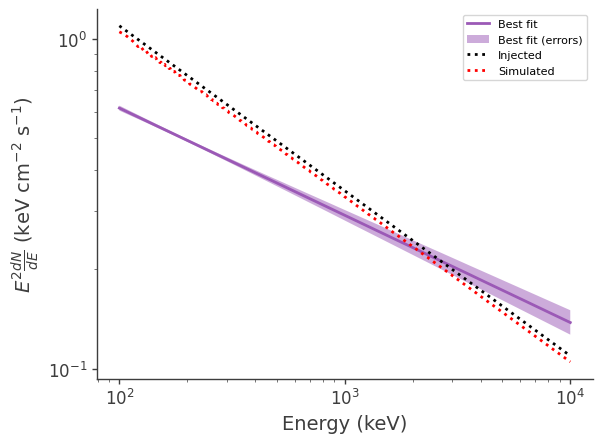

In [16]:
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Best fit")
ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Best fit (errors)")
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")
ax.plot(e_values, e_values*e_values*spec_values, color = 'red', ls = ":", label = "Simulated")


ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ (keV cm$^{-2}$ s$^{-1}$)")

ax.legend()
plt.show()
# fig.savefig('./Spectral_fitting_4cp2135_flare_11.png')
plt.close()

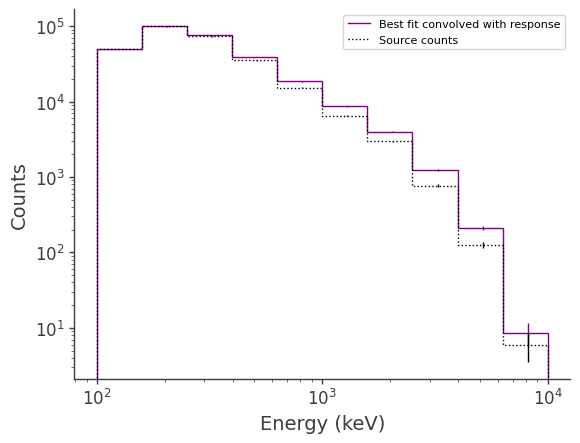

In [17]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents, yerr=np.sqrt(expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(blazar.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Source counts")
ax.errorbar(binned_energy, blazar.binned_data.project('Em').todense().contents, yerr=np.sqrt(blazar.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

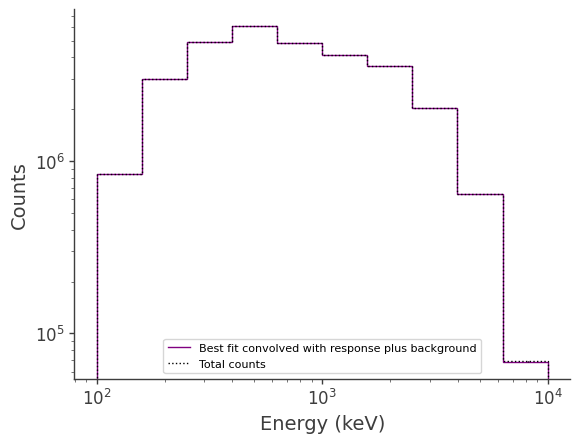

In [18]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), binned_energy_edges, color='purple', label = "Best fit convolved with response plus background")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), yerr=np.sqrt(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents)), color='purple', linewidth=0, elinewidth=1)
ax.stairs(blazar_bkg.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Total counts")
ax.errorbar(binned_energy, blazar_bkg.binned_data.project('Em').todense().contents, yerr=np.sqrt(blazar_bkg.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

In [22]:
# blazar_bkg.get_raw_lightcurve(binned_data=data_path / "4cp2135_albedo_bkg_binned_data.hdf5", output_name="lc_blazar")
# time, rate = np.loadtxt("lc_flare.dat", skiprows=1, unpack=True)
# plt.scatter(time, rate)
# plt.xlabel('Time')
# plt.ylabel('Rate (cts/s)')
# plt.title('Raw Lightcurve')
# # plt.savefig('/home/srinadb/cosipy/docs/tutorials/spectral_fits/continuum_fit/4Cp2135/results/raw_lc_4cp2135.png', dpi=200)
# plt.show()
# plt.close()

Compute integral flux from the fitted spectrum

In [19]:
simulated_flux = 0.007293201590129727


In [20]:
# https://threeml.readthedocs.io/en/latest/notebooks/flux_examples.html
# Get the simulated flux from the below
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC2/sources/Galactic/Crab/Crab.source

threeML_config.point_source.integrate_flux_method = "quad" # trapz, quad
result_fl=results.get_flux(
        ene_min= 100. * u.keV,
        ene_max= 10000. * u.keV,
        confidence_level=0.68,
        sum_sources=True,
        flux_unit="1/(cm2 s)" # 1/(cm2 s) (for integral photon flux) and keV/(cm2 s) or erg/(cm2 s) (for integral photon flux)
    )
print(result_fl)
# fl.flux.apply(lambda x: float(str(x).split()[1])).values[0]

print('\nThe simulated flux is: '+str(simulated_flux)+'\n')
print('Flux from the fitted spectrum (quad) is: '+str(result_fl["flux"].values[0].value)+'')

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

                                   flux                         low bound  \
total  0.004645578574446108 1 / (s cm2)  0.004598299855786138 1 / (s cm2)   

                               hi bound  
total  0.004693350199589207 1 / (s cm2)  

The simulated flux is: 0.007293201590129727

Flux from the fitted spectrum (quad) is: 0.004645578574446108


In [21]:
# https://threeml.readthedocs.io/en/latest/notebooks/flux_examples.html
# Get the simulated flux from the below
# https://github.com/cositools/cosi-sim/blob/main/cosi_sim/Source_Library/DC2/sources/GRBs/GRB090206620/GRB090206620.source

threeML_config.point_source.integrate_flux_method = "trapz" # trapz, quad
result_fl=results.get_flux(
        ene_min= 100. * u.keV,
        ene_max= 10000. * u.keV,
        confidence_level=0.95,
        sum_sources=True,
        flux_unit="1/(cm2 s)" # 1/(cm2 s) (for integral photon flux) and keV/(cm2 s) or erg/(cm2 s) (for integral photon flux)
    )
print(result_fl)
# fl.flux.apply(lambda x: float(str(x).split()[1])).values[0]

print('\nThe simulated flux is: '+str(simulated_flux)+'\n')
print('Flux from the fitted spectrum (trapz) is: '+str(result_fl["flux"].values[0].value)+'')

processing MLE analyses:   0%|                            | 0/1 [00:00<?, ?it/s]

                                   flux                         low bound  \
total  0.007887559986716312 1 / (s cm2)  0.007707343252003874 1 / (s cm2)   

                              hi bound  
total  0.00807589311521057 1 / (s cm2)  

The simulated flux is: 0.007293201590129727

Flux from the fitted spectrum (trapz) is: 0.007887559986716312
